In [19]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Pyclustering dependencies
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric

# Global seed
SEED = 42
random.seed(SEED)

# Folder structure configurations
RESULTS_DIR = "results_17_01"   # JSON input
RESULTS_CSV_DIR = "results_csv_clean_2" # Output root for CSVs and clustering
os.makedirs(RESULTS_CSV_DIR, exist_ok=True)

# Known folder “labels”
S_FOLDERS   = ["s_8", "s_15", "s_25"]
DISTANCES   = ["smooth", "uniform", "hamming", "overall"]
NOISE_LEVELS = ["n_0.02", "n_0.04", "n_0.06"]

# Map s_x to # of clusters
CLUSTER_MAPPING = {
    "s_8": 8,
    "s_15": 15,
    "s_25": 25
}


In [20]:
def parse_filename(filename, s_values, distances, noise_values):
    """
    Parse the filename to find:
      - which s_folder (e.g., 's_8', 's_15', 's_25')
      - which distance ('smooth', 'uniform', 'hamming', 'overall')
      - which noise level ('n_0.02', 'n_0.04', 'n_0.06')

    Returns: (s_folder, distance, noise)

    Raises ValueError if anything is missing or not found.
    """
    # 1. Find s_folder
    s_folder = None
    for s_val in s_values:
        if s_val in filename:
            s_folder = s_val
            break
    if not s_folder:
        raise ValueError(f"Could not parse s_folder (s_8, s_15, s_25) from {filename}")

    # 2. Find distance
    distance = None
    for dist in distances:
        if dist in filename:
            distance = dist
            break
    # If nothing found, default to "smooth"
    if not distance:
        distance = "smooth"

    # 3. Find noise level
    noise = None
    for nv in noise_values:
        if nv in filename:
            noise = nv
            break
    if not noise:
        raise ValueError(f"Could not parse noise level (n_0.02, n_0.04, n_0.06) from {filename}")

    return s_folder, distance, noise


In [21]:
def load_data(json_path):
    """
    Loads JSON data into a dictionary of DataFrames/Series
    (similar to your existing logic).
    """
    with open(json_path, 'r') as file:
        data = json.load(file)

    parsed_data = {}
    for key, value in data.items():
        if isinstance(value, list):
            try:
                arr = np.array(value)
                if arr.ndim == 1:
                    parsed_data[key] = pd.Series(value)
                elif arr.ndim == 2:
                    parsed_data[key] = pd.DataFrame(value)
                else:
                    # If it's a list of lists-of-lists, convert each slice
                    parsed_data[key] = {
                        i: pd.DataFrame(subarr) for i, subarr in enumerate(arr)
                    }
            except ValueError:
                # Fallback if direct array conversion fails
                parsed_data[key] = {
                    i: pd.DataFrame(subarr) for i, subarr in enumerate(value) if isinstance(subarr, list)
                }
        else:
            parsed_data[key] = value

    return parsed_data


def create_folder_structure():
    """
    Create the 3-level folder structure under RESULTS_CSV_DIR:
        s_* / distance / n_*
    But do not create subfolders yet for Dw/Dkl; that happens dynamically.
    """
    for s_val in S_FOLDERS:
        s_path = os.path.join(RESULTS_CSV_DIR, s_val)
        os.makedirs(s_path, exist_ok=True)
        for dist in DISTANCES:
            dist_path = os.path.join(s_path, dist)
            os.makedirs(dist_path, exist_ok=True)
            for nv in NOISE_LEVELS:
                noise_path = os.path.join(dist_path, nv)
                os.makedirs(noise_path, exist_ok=True)


def process_json_files():
    """
    For each JSON in RESULTS_DIR:
      1) parse s_folder, distance, noise
      2) load JSON data
      3) create subfolder named after the filename (minus .json)
      4) for each key in 'parsed_data' that starts with 'all_', create a
         corresponding sub-subfolder and save each matrix to CSV.
    """
    for filename in os.listdir(RESULTS_DIR):
        if not filename.endswith(".json"):
            continue
        
        # parse s_folder, distance, noise
        s_folder, distance, noise = parse_filename(
            filename,
            s_values=S_FOLDERS,
            distances=DISTANCES,
            noise_values=NOISE_LEVELS
        )
        
        # load data
        json_path = os.path.join(RESULTS_DIR, filename)
        parsed_data = load_data(json_path)

        # build the subfolder path: results_csv/s_folder/distance/noise/<run_name>/
        run_name = os.path.splitext(filename)[0]
        run_path = os.path.join(RESULTS_CSV_DIR, s_folder, distance, noise, run_name)
        os.makedirs(run_path, exist_ok=True)

        # For each key in parsed_data that starts with "all_", create a subfolder
        for key, val in parsed_data.items():
            if not key.startswith("all_"):
                continue

            # e.g., key = "all_Dw" => subfolder name = "Dw"
            subfolder_name = key.replace("all_", "")
            subfolder_path = os.path.join(run_path, subfolder_name)
            os.makedirs(subfolder_path, exist_ok=True)

            # val could be a dict of DataFrames or a single DataFrame
            # Often in your code it's a dict: { i: DataFrame, i: DataFrame, ... }
            # So handle that scenario:
            if isinstance(val, dict):
                # Save each matrix to CSV
                for i, df in val.items():
                    csv_path = os.path.join(subfolder_path, f"{subfolder_name}_{i}.csv")
                    df.to_csv(csv_path, index=False, header=False)
            elif isinstance(val, pd.DataFrame):
                # Single DF scenario
                csv_path = os.path.join(subfolder_path, f"{subfolder_name}.csv")
                val.to_csv(csv_path, index=False, header=False)
            else:
                # Possibly a Series or something else
                # Adjust if needed
                pass


In [22]:
def pam_cosine_clustering(data, n_clusters, random_seed=SEED):
    """
    Performs k-medoids (PAM) with cosine distance.
    data shape expected: (num_bins, num_signatures).
    Returns: (clusters, medoid_signatures)
    """
    # Convert to NumPy
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()

    # Transpose => (num_signatures, num_bins)
    data = data.T
    num_signatures, _ = data.shape

    if n_clusters > num_signatures:
        raise ValueError(f"Requested {n_clusters} clusters, but only {num_signatures} signatures available.")

    # Define custom distance
    def custom_cosine_distance(a, b):
        return cdist([a], [b], "cosine")[0, 0]

    metric = distance_metric(type_metric.USER_DEFINED, func=custom_cosine_distance)
    initial_medoids = random.sample(range(num_signatures), n_clusters)

    kmed = kmedoids(data.tolist(), initial_medoids, metric=metric)
    kmed.process()
    clusters = kmed.get_clusters()
    medoids = kmed.get_medoids()
    medoid_signatures = np.array([data[idx] for idx in medoids])
    return clusters, medoid_signatures

def load_and_cluster(folder_path, n_clusters, output_csv_path, random_seed=SEED):
    """
    Loads CSV files in `folder_path`, concatenates them, does PAM clustering,
    and saves the medoids to `output_csv_path`.
    """
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    if not csv_files:
        print(f"No CSV files in {folder_path}, skipping.")
        return None, None

    matrices = []
    for f in csv_files:
        mat = pd.read_csv(os.path.join(folder_path, f), header=None)
        matrices.append(mat)

    combined_data = pd.concat(matrices, axis=1)  # horizontally
    clusters, medoids = pam_cosine_clustering(combined_data, n_clusters, random_seed)

    # Save medoids
    pd.DataFrame(medoids.T).to_csv(output_csv_path, index=False, header=False)
    print(f"Medoid signatures saved to: {output_csv_path}")
    
    return clusters, medoids






results_csv /
    s_15 /
        uniform /
            n_0.02 /
                <run_name> /
                    Dw /
                    Dkl /
                    ...


In [21]:
def traverse_folders(root_dir, s_values, distances, noise_values):
    """
    Yields (s_folder, distance, noise, run_folder, subfolder_path)
    for each folder that actually exists under:
        root_dir / s_folder / distance / noise / run_folder / ...
    We'll pick up any sub-subfolders under run_folder.
    """
    for s_val in s_values:
        s_path = os.path.join(root_dir, s_val)
        if not os.path.exists(s_path):
            continue
        for dist in distances:
            dist_path = os.path.join(s_path, dist)
            if not os.path.exists(dist_path):
                continue
            for nv in noise_values:
                noise_path = os.path.join(dist_path, nv)
                if not os.path.exists(noise_path):
                    continue
                # each run_folder is the JSON-based folder name
                for run_folder in os.listdir(noise_path):
                    run_path = os.path.join(noise_path, run_folder)
                    if not os.path.isdir(run_path):
                        continue
                    # now yield any subfolder inside run_path
                    for subfolder in os.listdir(run_path):
                        subfolder_path = os.path.join(run_path, subfolder)
                        if os.path.isdir(subfolder_path):
                            yield (s_val, dist, nv, run_folder, subfolder_path)


In [24]:
def run_clustering():
    for s_val, dist, noise, run_name, subfolder_path in traverse_folders(
        root_dir=RESULTS_CSV_DIR,
        s_values=S_FOLDERS,
        distances=DISTANCES,
        noise_values=NOISE_LEVELS
    ):
        # Filter so we only process "Dw" or "Dkl" subfolders
        subfolder_name = os.path.basename(subfolder_path)
        if subfolder_name not in ("Dw", "Dkl"):
            continue

        n_clusters = CLUSTER_MAPPING[s_val]
        output_csv = os.path.join(subfolder_path, f"medoids_{subfolder_name}.csv")

        print(f"Clustering {subfolder_path} -> {output_csv} with k={n_clusters}")
        clusters, medoids = load_and_cluster(
            folder_path=subfolder_path,
            n_clusters=n_clusters,
            output_csv_path=output_csv,
            random_seed=SEED
        )

In [25]:
import re

# Suppose these are the known JSON filenames for each s_x:
file_map = {
    "s_8":  "Results_20250117_154939_overall_s_8_n_0.02__GRCh37_98_86_39_22a_43_96_37_54.json",
    "s_15": "Results_20250117_154127__s_15_n_0.02__GRCh37_98_86_39_22a_43_96_37_54_87_17b_21_99_3_33_93.json",
    "s_25": "Results_20250117_154536__s_25_n_0.02__GRCh37_98_86_39_22a_43_96_37_54_87_17b_21_99_3_33_93_26_12_22b_17a_9_25_55_89_13_46"
}

def save_ground_truth_signatures(cosmic_signatures_path):
    """
    Loads the cosmic signatures, extracts the relevant SBS IDs from each JSON
    file name (the portion after GRCh37_), and saves them to CSV in their
    corresponding s_x folder.
    """
    cosmic_df = pd.read_csv(cosmic_signatures_path, sep="\t")
    # If there's a column "Type", set as index
    if "Type" in cosmic_df.columns:
        cosmic_df.set_index("Type", inplace=True)

    # For each s_folder + known JSON filename:
    for s_val, fname in file_map.items():
        match = re.search(r"GRCh37_([\w\d_]+)", fname)
        if not match:
            print(f"No signature portion found in {fname}, skipping.")
            continue
        sig_portion = match.group(1)
        sbs_ids = sig_portion.split("_")  # like ["98","86","39","22a",...]
        # Prepend "SBS" to each id
        # watch out if you have "22a" or "17b" etc. — adjust if needed
        signature_names = [f"SBS{id_}" for id_ in sbs_ids]

        # Filter cosmic
        filtered_sigs = cosmic_df[signature_names]

        # Save to CSV
        out_path = os.path.join(RESULTS_CSV_DIR, s_val, f"ground_truth_signatures_{s_val}.csv")
        filtered_sigs.to_csv(out_path, index=True)
        print(f"Saved ground truth to {out_path}")



In [ ]:
# 1) Create the standard 3-level directory 
create_folder_structure()

# 2) Convert JSON => CSV subfolders
process_json_files()

# 3) Run clustering on each subfolder
run_clustering()




In [18]:

def evaluation(true_sigs, est_sigs, cutoff=0.9, dist="cos"):
    """
    Evaluate extracted sigs (est_sigs) vs. true_sigs.
    Returns a tuple with (n_ground_truth, n_detected, tp, fp, fn, precision, recall, f1, index_map).
    """
    if true_sigs.shape[1] >= est_sigs.shape[1]:
        mat1, mat2 = est_sigs, true_sigs
    else:
        mat1, mat2 = true_sigs, est_sigs

    if dist == "cos":
        con_mat = cdist(mat1.T, mat2.T, "cosine")
    elif dist == "cor":
        con_mat = cdist(mat1.T, mat2.T, "correlation")
    else:
        raise ValueError("Distance must be 'cos' or 'cor'")

    # Hungarian assignment
    row_ind, col_ind = linear_sum_assignment(con_mat)
    similarity_mat = 1 - con_mat  # convert distance -> similarity

    idx_map = {}
    tp = 0
    for r, c in zip(row_ind, col_ind):
        idx_map[r] = c
        if similarity_mat[r, c] >= cutoff:
            tp += 1

    computed_fp = mat1.shape[1] - tp
    computed_fn = computed_fp
    if true_sigs.shape[1] >= est_sigs.shape[1]:
        base_fp = 0
        base_fn = true_sigs.shape[1] - est_sigs.shape[1]
    else:
        base_fp = est_sigs.shape[1] - true_sigs.shape[1]
        base_fn = 0

    fp = base_fp + computed_fp
    fn = base_fn + computed_fn

    n_gt = true_sigs.shape[1]
    n_detected = est_sigs.shape[1]

    try:
        precision = round(tp / (tp + fp), 2)
        recall    = round(tp / (tp + fn), 2)
        f1_score  = round(2 * precision * recall / (precision + recall), 2)
    except ZeroDivisionError:
        precision, recall, f1_score = 0, 0, 0

    return (n_gt, n_detected, tp, fp, fn, precision, recall, f1_score, idx_map)

def run_evaluation(cutoff=0.9):
    """
    For each subfolder with medoids_<subfolder>.csv,
    read the corresponding ground truth, evaluate, save results in .txt,
    but ONLY for 'Dw' or 'Dkl'.
    """
    for s_val, dist, noise, run_name, subfolder_path in traverse_folders(
        root_dir=RESULTS_CSV_DIR,
        s_values=S_FOLDERS,
        distances=DISTANCES,
        noise_values=NOISE_LEVELS
    ):
        subfolder_name = os.path.basename(subfolder_path)
        
        # Skip any subfolder that is not Dw or Dkl
        if subfolder_name not in ("Dw", "Dkl"):
            continue
        
        gt_csv = os.path.join(RESULTS_CSV_DIR, s_val, f"ground_truth_signatures_{s_val}.csv")
        if not os.path.exists(gt_csv):
            continue
        
        true_signatures = pd.read_csv(gt_csv, index_col=0).to_numpy()
        
        # Medoids file path depends on subfolder name (Dw or Dkl)
        medoids_csv = os.path.join(subfolder_path, f"medoids_{subfolder_name}.csv")
        if not os.path.exists(medoids_csv):
            continue
        
        est_signatures = pd.read_csv(medoids_csv, header=None).to_numpy()
        
        # Run evaluation
        eval_res = evaluation(
            true_sigs=true_signatures,
            est_sigs=est_signatures,
            cutoff=cutoff,
            dist="cos"
        )
        
        # Write results
        eval_txt = os.path.join(subfolder_path, f"evaluation_{subfolder_name}.txt")
        with open(eval_txt, "w") as f:
            f.write("=== Evaluation Results ===\n")
            f.write(f"Cutoff: {cutoff}\n")
            f.write(f"s_folder: {s_val}\n")
            f.write(f"distance: {dist}\n")
            f.write(f"noise: {noise}\n")
            f.write(f"run_folder: {run_name}\n")
            f.write(f"subfolder: {subfolder_name}\n")
            f.write(f"Number of Ground Truth: {eval_res[0]}\n")
            f.write(f"Number of Detected: {eval_res[1]}\n")
            f.write(f"True Positives: {eval_res[2]}\n")
            f.write(f"False Positives: {eval_res[3]}\n")
            f.write(f"False Negatives: {eval_res[4]}\n")
            f.write(f"Precision: {eval_res[5]}\n")
            f.write(f"Recall: {eval_res[6]}\n")
            f.write(f"F1 Score: {eval_res[7]}\n")
            f.write("Index Pairs (Extracted -> Ground Truth):\n")
            for e_idx, t_idx in eval_res[8].items():
                f.write(f"  Extracted {e_idx} -> Ground Truth {t_idx}\n")

        print(f"Evaluation written to {eval_txt}")


In [17]:


# EVALUATION WITHOUT HUNGARIAN RE-ARRANGMENT

def evaluation_figS1(true_sigs, est_sigs, cutoff=0.9, dist="cos"):
    """
    Evaluate extracted sigs (est_sigs) vs. true_sigs in a “Figure S1” style:
      - Each extracted signature is TP if it matches (>= cutoff) at least one ground-truth signature.
      - Otherwise it is FP.
      - A ground-truth signature is FN if no extracted signature matches it above the cutoff.
    Returns:
      n_ground_truth, n_detected, tp, fp, fn, precision, recall, f1_score
    """
    # Number of ground-truth and extracted signatures
    n_gt = true_sigs.shape[1]
    n_detected = est_sigs.shape[1]

    # Compute pairwise distance matrix => then convert to similarity
    if dist == "cos":
        D = cdist(est_sigs.T, true_sigs.T, metric="cosine")  # shape: (n_detected, n_gt)
    elif dist == "cor":
        D = cdist(est_sigs.T, true_sigs.T, metric="correlation")
    else:
        raise ValueError("Distance must be 'cos' or 'cor'")

    similarity = 1 - D  # Convert distance to similarity if using cosine/correlation

    # (1) Classify each extracted signature
    # max similarity to any ground-truth signature
    max_sim_extracted = np.max(similarity, axis=1)  # shape: (n_detected,)
    # True positives are those that exceed the cutoff
    tp = np.sum(max_sim_extracted >= cutoff)
    # False positives are those that do not match any ground-truth signature above cutoff
    fp = n_detected - tp

    # (2) Classify each ground-truth signature
    # max similarity of each ground-truth signature to any extracted signature
    max_sim_truth = np.max(similarity, axis=0)  # shape: (n_gt,)
    # False negatives are ground-truth signatures not matched by any extracted signature
    fn = np.sum(max_sim_truth < cutoff)

    # (3) Precision/Recall/F1
    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = 0.0
    if (precision + recall) == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * precision * recall / (precision + recall)

    # Round to 2 decimals for reporting
    precision = round(precision, 2)
    recall    = round(recall, 2)
    f1_score  = round(f1_score, 2)

    return (n_gt, n_detected, tp, fp, fn, precision, recall, f1_score)


In [16]:

def run_evaluation_figS1(cutoff=0.8):
    """
    For each subfolder with medoids_<subfolder>.csv,
    read the corresponding ground truth, evaluate using the “Figure S1” method,
    save results in evaluation_figS1_<subfolder>.txt,
    but ONLY for 'Dw' or 'Dkl' subfolders.
    """
    for s_val, dist, noise, run_name, subfolder_path in traverse_folders(
        root_dir=RESULTS_CSV_DIR,
        s_values=S_FOLDERS,
        distances=DISTANCES,
        noise_values=NOISE_LEVELS
    ):
        subfolder_name = os.path.basename(subfolder_path)
        
        # Skip any subfolder that is not Dw or Dkl
        if subfolder_name not in ("Dw", "Dkl"):
            continue
        
        # Path to ground-truth signatures
        gt_csv = os.path.join(RESULTS_CSV_DIR, s_val, f"ground_truth_signatures_{s_val}.csv")
        if not os.path.exists(gt_csv):
            continue
        
        true_signatures = pd.read_csv(gt_csv, index_col=0).to_numpy()
        
        # Path to medoids (extracted signatures)
        medoids_csv = os.path.join(subfolder_path, f"medoids_{subfolder_name}.csv")
        if not os.path.exists(medoids_csv):
            continue
        
        est_signatures = pd.read_csv(medoids_csv, header=None).to_numpy()
        
        # Run “Figure S1” evaluation
        eval_res = evaluation_figS1(
            true_sigs=true_signatures,
            est_sigs=est_signatures,
            cutoff=cutoff,
            dist="cos"  # or "cor" if you want correlation
        )
        
        # Unpack results
        n_gt, n_detected, tp, fp, fn, precision, recall, f1_score = eval_res
        
        # Write results
        eval_txt = os.path.join(subfolder_path, f"evaluation_figS1_{subfolder_name}.txt")
        with open(eval_txt, "w") as f:
            f.write("=== Evaluation Results (Figure S1 Style) ===\n")
            f.write(f"Cutoff: {cutoff}\n")
            f.write(f"s_folder: {s_val}\n")
            f.write(f"distance: {dist}\n")
            f.write(f"noise: {noise}\n")
            f.write(f"run_folder: {run_name}\n")
            f.write(f"subfolder: {subfolder_name}\n")
            f.write(f"Number of Ground Truth: {n_gt}\n")
            f.write(f"Number of Detected: {n_detected}\n")
            f.write(f"True Positives: {tp}\n")
            f.write(f"False Positives: {fp}\n")
            f.write(f"False Negatives: {fn}\n")
            f.write(f"Precision: {precision}\n")
            f.write(f"Recall: {recall}\n")
            f.write(f"F1 Score: {f1_score}\n")

        print(f"Figure S1-style evaluation written to {eval_txt}")


In [56]:
run_evaluation_figS1(cutoff=0.7)

Figure S1-style evaluation written to results_csv_clean/s_8/smooth/n_0.02/Results_20250117_154856__s_8_n_0.02__GRCh37_98_86_39_22a_43_96_37_54/Dw/evaluation_figS1_Dw.txt
Figure S1-style evaluation written to results_csv_clean/s_8/smooth/n_0.02/Results_20250117_154856__s_8_n_0.02__GRCh37_98_86_39_22a_43_96_37_54/Dkl/evaluation_figS1_Dkl.txt
Figure S1-style evaluation written to results_csv_clean/s_8/smooth/n_0.04/Results_20250117_155023__s_8_n_0.04__GRCh37_98_86_39_22a_43_96_37_54/Dw/evaluation_figS1_Dw.txt
Figure S1-style evaluation written to results_csv_clean/s_8/smooth/n_0.04/Results_20250117_155023__s_8_n_0.04__GRCh37_98_86_39_22a_43_96_37_54/Dkl/evaluation_figS1_Dkl.txt
Figure S1-style evaluation written to results_csv_clean/s_8/smooth/n_0.06/Results_20250117_155159__s_8_n_0.06__GRCh37_98_86_39_22a_43_96_37_54/Dw/evaluation_figS1_Dw.txt
Figure S1-style evaluation written to results_csv_clean/s_8/smooth/n_0.06/Results_20250117_155159__s_8_n_0.06__GRCh37_98_86_39_22a_43_96_37_54/Dkl

In [57]:
# 4) Save ground-truth signatures from your known “file_map”
COSMIC_SIGNATURES_PATH = "cosmic_signatures/COSMIC_v3.4_SBS_GRCh37.txt"
save_ground_truth_signatures(COSMIC_SIGNATURES_PATH)

# 5) Evaluate
run_evaluation(cutoff=0.7)

Saved ground truth to results_csv_clean/s_8/ground_truth_signatures_s_8.csv
Saved ground truth to results_csv_clean/s_15/ground_truth_signatures_s_15.csv
Saved ground truth to results_csv_clean/s_25/ground_truth_signatures_s_25.csv
Evaluation written to results_csv_clean/s_8/smooth/n_0.02/Results_20250117_154856__s_8_n_0.02__GRCh37_98_86_39_22a_43_96_37_54/Dw/evaluation_Dw.txt
Evaluation written to results_csv_clean/s_8/smooth/n_0.02/Results_20250117_154856__s_8_n_0.02__GRCh37_98_86_39_22a_43_96_37_54/Dkl/evaluation_Dkl.txt
Evaluation written to results_csv_clean/s_8/smooth/n_0.04/Results_20250117_155023__s_8_n_0.04__GRCh37_98_86_39_22a_43_96_37_54/Dw/evaluation_Dw.txt
Evaluation written to results_csv_clean/s_8/smooth/n_0.04/Results_20250117_155023__s_8_n_0.04__GRCh37_98_86_39_22a_43_96_37_54/Dkl/evaluation_Dkl.txt
Evaluation written to results_csv_clean/s_8/smooth/n_0.06/Results_20250117_155159__s_8_n_0.06__GRCh37_98_86_39_22a_43_96_37_54/Dw/evaluation_Dw.txt
Evaluation written to re

In [ ]:

evaluation_figS1()

In [5]:
est_sigs_path = "results_csv_clean/s_8/hamming/n_0.02/Results_20250117_155001_hamming_s_8_n_0.02__GRCh37_98_86_39_22a_43_96_37_54/Dkl/Dkl_0.csv"
est_sigs2_path ="results_csv_clean/s_8/hamming/n_0.02/Results_20250117_155001_hamming_s_8_n_0.02__GRCh37_98_86_39_22a_43_96_37_54/Dkl/medoids_Dkl.csv"

true_sigs_path = "/Users/lorispodevyn/Documents/COURSES/PROJECT_MASTER_1/Code/Mutational_Signatures/results_csv_clean/s_8/ground_truth_signatures_s_8.csv"

# Load CSV data
est_sigs = pd.read_csv(est_sigs_path, header=None).values
est_sigs2 = pd.read_csv(est_sigs2_path, header=None).values
true_sigs = pd.read_csv(true_sigs_path, header=None).values
true_sigs = true_sigs[1:, 1:]


print("Shape of est_sigs:", est_sigs.shape)
print("Shape of true_sigs:", true_sigs.shape)

# Evaluate
results = evaluation_figS1(true_sigs, est_sigs,cutoff=0.5)
results2 = evaluation_figS1(true_sigs, est_sigs2,cutoff=0.5)
# Print all the results
print("Evaluation Results:")
print(f"Number of ground-truth signatures (n_gt): {results[0]}")
print(f"Number of detected signatures (n_detected): {results[1]}")
print(f"True Positives (TP): {results[2]}")
print(f"False Positives (FP): {results[3]}")
print(f"False Negatives (FN): {results[4]}")
print(f"Precision: {results[5]}")
print(f"Recall: {results[6]}")
print(f"F1 Score: {results[7]}")


print("Evaluation Results medois :")
print(f"Number of ground-truth signatures (n_gt): {results2[0]}")
print(f"Number of detected signatures (n_detected): {results2[1]}")
print(f"True Positives (TP): {results2[2]}")
print(f"False Positives (FP): {results2[3]}")
print(f"False Negatives (FN): {results2[4]}")
print(f"Precision: {results2[5]}")
print(f"Recall: {results2[6]}")
print(f"F1 Score: {results2[7]}")

Shape of est_sigs: (96, 8)
Shape of true_sigs: (96, 8)
Evaluation Results:
Number of ground-truth signatures (n_gt): 8
Number of detected signatures (n_detected): 8
True Positives (TP): 8
False Positives (FP): 0
False Negatives (FN): 5
Precision: 1.0
Recall: 0.62
F1 Score: 0.76
Evaluation Results medois :
Number of ground-truth signatures (n_gt): 8
Number of detected signatures (n_detected): 8
True Positives (TP): 8
False Positives (FP): 0
False Negatives (FN): 5
Precision: 1.0
Recall: 0.62
F1 Score: 0.76


# **Visualizations**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_side_by_side_heatmaps(
    true_sigs: np.ndarray,
    extracted_sigs: np.ndarray,
    match_indices=None,
    title="True vs. Extracted Signatures",
    cmap="viridis",
    figsize=(12, 6),
    save_path=None
):
    """
    Plots two heatmaps side by side:
      Left  = true_sigs (shape: bins x #true_signatures)
      Right = extracted_sigs (shape: bins x #extracted_signatures)
    
    Parameters:
    -----------
    true_sigs : np.ndarray
        2D array (bins x signatures).
    extracted_sigs : np.ndarray
        2D array (bins x signatures).
    match_indices : list or dict, optional
        If using Hungarian, you can pass a dict {extracted_col_index: true_col_index}
        to reorder columns in extracted_sigs for visual alignment.
    title : str
        Plot title.
    cmap : str
        Color map for heatmaps.
    figsize : tuple
        Figure size.
    save_path : str or None
        If given, the figure will be saved to this path.
    """

    # If we have Hungarian matching, reorder columns in extracted_sigs
    if match_indices is not None:
        # match_indices is typically extracted_idx -> true_idx
        # so we reorder 'extracted_sigs' by the true_idx
        # so that extracted_sigs[:, i] lines up with true_sigs[:, matched_true]
        # We just create a new array in the matched order:
        # sorted by the value of match_indices in ascending order
        sorted_pairs = sorted(match_indices.items(), key=lambda x: x[1])
        reordered = [extracted_sigs[:, p[0]] for p in sorted_pairs]
        extracted_sigs = np.column_stack(reordered)

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Left heatmap: true sigs
    sns.heatmap(
        true_sigs, ax=axes[0], cmap=cmap, cbar=False
    )
    axes[0].set_title("True Signatures")

    # Right heatmap: extracted sigs
    sns.heatmap(
        extracted_sigs, ax=axes[1], cmap=cmap, cbar=True
    )
    axes[1].set_title("Extracted Signatures")

    fig.suptitle(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


In [12]:
def reorder_extracted_signatures(extracted_sigs, idx_map):
    """
    Reorders columns of extracted_sigs to match the ground-truth index from Hungarian.
    idx_map is {extracted_idx: true_idx}.
    We'll sort by true_idx ascending.
    """
    sorted_pairs = sorted(idx_map.items(), key=lambda x: x[1])
    reordered = [extracted_sigs[:, ex_idx] for (ex_idx, _) in sorted_pairs]
    return np.column_stack(reordered) if reordered else extracted_sigs


def plot_all_runs_with_traverse(
    root_dir,
    s_values,
    distances,
    noise_values,
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged", # else not_arranged
    cutoff=0.9,
    dist_metric="cos",
    plot_only_medoids=True,
    cmap="viridis",
    scale_heatmap=True  # New option to scale or not
):
    # Cache ground truth so we don't reload multiple times
    ground_truth_cache = {}

    for s_val, dist, noise, run_folder, subfolder_path in traverse_folders(
        root_dir=root_dir,
        s_values=s_values,
        distances=distances,
        noise_values=noise_values
    ):
        subfolder_name = os.path.basename(subfolder_path)
        if subfolder_name not in subfolders:
            continue  # skip if it's not Dw or Dkl

        # Load ground-truth from results_csv_clean/s_val/ground_truth_signatures_s_val.csv
        if s_val not in ground_truth_cache:
            gt_path = os.path.join(root_dir, s_val, f"ground_truth_signatures_{s_val}.csv")
            if not os.path.exists(gt_path):
                print(f"No ground truth found at {gt_path}, skipping {s_val}.")
                continue
            ground_truth_df = pd.read_csv(gt_path, index_col=0)
            ground_truth_cache[s_val] = ground_truth_df.to_numpy()
            ground_truth_labels = ground_truth_df.columns.to_list()

        true_sigs = ground_truth_cache[s_val]

        # Gather the CSV files in subfolder
        if not os.path.isdir(subfolder_path):
            continue

        if plot_only_medoids:
            med_name = f"medoids_{subfolder_name}.csv"
            csv_files = [med_name] if os.path.exists(os.path.join(subfolder_path, med_name)) else []
        else:
            csv_files = [f for f in os.listdir(subfolder_path) if f.endswith(".csv")]

        for csv_file in csv_files:
            csv_path = os.path.join(subfolder_path, csv_file)
            if not os.path.exists(csv_path):
                continue

            est_sigs = pd.read_csv(csv_path, header=None).to_numpy()

            # Evaluate
            if evaluation_method == "rearranged":
                eval_res = evaluation(true_sigs, est_sigs, cutoff=cutoff, dist=dist_metric)
                (n_gt, n_det, tp, fp, fn, precision, recall, f1_score, idx_map) = eval_res
                est_sigs_aligned = reorder_extracted_signatures(est_sigs, idx_map)
            elif evaluation_method == "not_arranged":
                eval_res = evaluation_figS1(true_sigs, est_sigs, cutoff=cutoff, dist=dist_metric)
                (n_gt, n_det, tp, fp, fn, precision, recall, f1_score) = eval_res
                est_sigs_aligned = est_sigs
            else:
                raise ValueError("evaluation_method must be 'rearranged' or 'not_arranged'")

            # Apply scaling if enabled
            if scale_heatmap:
                vmin = min(true_sigs.min(), est_sigs_aligned.min())
                vmax = max(true_sigs.max(), est_sigs_aligned.max())
            else:
                vmin, vmax = None, None  # Let seaborn choose default scaling

            # Plot
            fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
            sns.heatmap(true_sigs, ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
            axes[0].set_title("True Signatures")
            axes[0].set_xticklabels(ground_truth_labels, rotation=45, ha='right')

            if csv_file.startswith("medoids_"):
                second_title = "Extracted medoids signatures"
            else:
                base_name = os.path.splitext(csv_file)[0]
                second_title = f"Extracted {base_name} signatures"

            sns.heatmap(est_sigs_aligned, ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True)
            axes[1].set_title(second_title)

            fig_title = (
                f"{evaluation_method.upper()} | Noise: {noise}, Distance: {dist}, Signatures: {s_val}, File: {csv_file}"
            )
            fig.suptitle(fig_title, fontsize=12)

            plt.tight_layout()
            plt.show()



In [ ]:

# Plot the first set of extracted signatures
plot_side_by_side_heatmaps(
    true_sigs=true_sigs.astype(float),
    extracted_sigs=est_sigs.astype(float),
    title="True vs. Extracted Signatures (Dkl_0)"
)

# Plot the second set of extracted signatures
plot_side_by_side_heatmaps(
    true_sigs=true_sigs.astype(float),
    extracted_sigs=est_sigs2.astype(float),
    title="True vs. Extracted Signatures (medoids_Dkl)"
)



In [131]:
def reorder_extracted_signatures(extracted_sigs, idx_map):
    """
    Reorders columns of extracted_sigs to match the ground-truth index from Hungarian.
    idx_map is {extracted_idx: true_idx}.
    We'll sort by true_idx ascending.
    """
    sorted_pairs = sorted(idx_map.items(), key=lambda x: x[1])
    reordered = [extracted_sigs[:, ex_idx] for (ex_idx, _) in sorted_pairs]
    return np.column_stack(reordered) if reordered else extracted_sigs


def plot_all_runs_with_traverse(
    root_dir,
    s_values,
    distances,
    noise_values,
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged", # else not_arranged
    cutoff=0.9,
    dist_metric="cos",
    plot_only_medoids=True,
    cmap="viridis",
    scale_heatmap=True  # New option to scale or not
):
    # Cache ground truth so we don't reload multiple times
    ground_truth_cache = {}


    for s_val, dist, noise, run_folder, subfolder_path in traverse_folders(
        root_dir=root_dir,
        s_values=s_values,
        distances=distances,
        noise_values=noise_values
    ):
        subfolder_name = os.path.basename(subfolder_path)
        if subfolder_name not in subfolders:
            continue  # skip if it's not Dw or Dkl

        # Load ground-truth from results_csv_clean/s_val/ground_truth_signatures_s_val.csv
        if s_val not in ground_truth_cache:
            gt_path = os.path.join(root_dir, s_val, f"ground_truth_signatures_{s_val}.csv")
            if not os.path.exists(gt_path):
                print(f"No ground truth found at {gt_path}, skipping {s_val}.")
                continue
            ground_truth_df = pd.read_csv(gt_path, index_col=0)
            ground_truth_cache[s_val] = ground_truth_df.to_numpy()
            ground_truth_labels = ground_truth_df.columns.to_list()

        true_sigs = ground_truth_cache[s_val]

        # Gather the CSV files in subfolder
        if not os.path.isdir(subfolder_path):
            continue

        if plot_only_medoids:
            med_name = f"medoids_{subfolder_name}.csv"
            csv_files = [med_name] if os.path.exists(os.path.join(subfolder_path, med_name)) else []
        else:
            csv_files = [f for f in os.listdir(subfolder_path) if f.endswith(".csv")]

        for csv_file in csv_files:
            csv_path = os.path.join(subfolder_path, csv_file)
            if not os.path.exists(csv_path):
                continue

            est_sigs = pd.read_csv(csv_path, header=None).to_numpy()

            # Evaluate
            if evaluation_method == "rearranged":
                eval_res = evaluation(true_sigs, est_sigs, cutoff=cutoff, dist=dist_metric)
                (n_gt, n_det, tp, fp, fn, precision, recall, f1_score, idx_map) = eval_res
                est_sigs_aligned = reorder_extracted_signatures(est_sigs, idx_map)
            elif evaluation_method == "not_arranged":
                eval_res = evaluation_figS1(true_sigs, est_sigs, cutoff=cutoff, dist=dist_metric)
                (n_gt, n_det, tp, fp, fn, precision, recall, f1_score) = eval_res
                est_sigs_aligned = est_sigs
            else:
                raise ValueError("evaluation_method must be 'rearranged' or 'not_arranged'")

            # Apply scaling if enabled
            if scale_heatmap:
                vmin = min(true_sigs.min(), est_sigs_aligned.min())
                vmax = max(true_sigs.max(), est_sigs_aligned.max())
            else:
                vmin, vmax = None, None  # Let seaborn choose default scaling

            # Plot
            fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
            sns.heatmap(true_sigs, ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
            axes[0].set_title("True Signatures")
            axes[0].set_xticklabels(ground_truth_labels, rotation=45, ha='right')

            if csv_file.startswith("medoids_"):
                second_title = "Extracted medoids signatures"
            else:
                base_name = os.path.splitext(csv_file)[0]
                second_title = f"Extracted {base_name} signatures"

            sns.heatmap(est_sigs_aligned, ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True)
            axes[1].set_title(second_title)
            
            subfolder_name_mapping = {
                "Dkl": "KL-NMF",
                "Dw": "W-NMF"
            }

            # Mapping noise values to readable names
            noise_mapping = {
                "n_0.02": "Low",
                "n_0.04": "Medium",
                "n_0.06": "High"
            }

            signature_mapping = {
                "s_8": "Eight extracted Signatures",
                "s_15": "Fifteen extracted Signatures",
                "s_25": "Twenty-five extracted Signatures"
            }

            # Get the correct descriptive names
            method_name = subfolder_name_mapping.get(subfolder_name, subfolder_name)
            noise_desc = noise_mapping.get(noise, noise)
            signature_desc = signature_mapping.get(s_val, s_val)

# Update the figure title with descriptive names and line breaks
            fig_title = (
               # f"{evaluation_method.upper()} \n"
                f"{signature_desc}\n"
                f"Noise level: {noise_desc}\n"
                f"Method used: {method_name} with {dist} distance"
            )

            fig.suptitle(fig_title, fontsize=12)

            plt.tight_layout()
            plt.show()


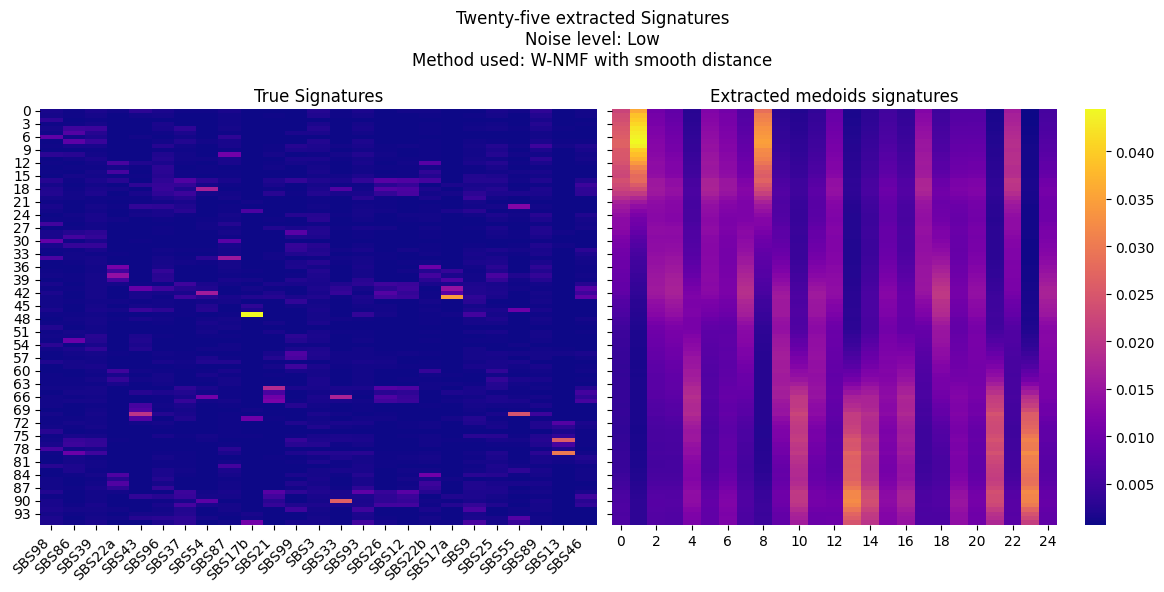

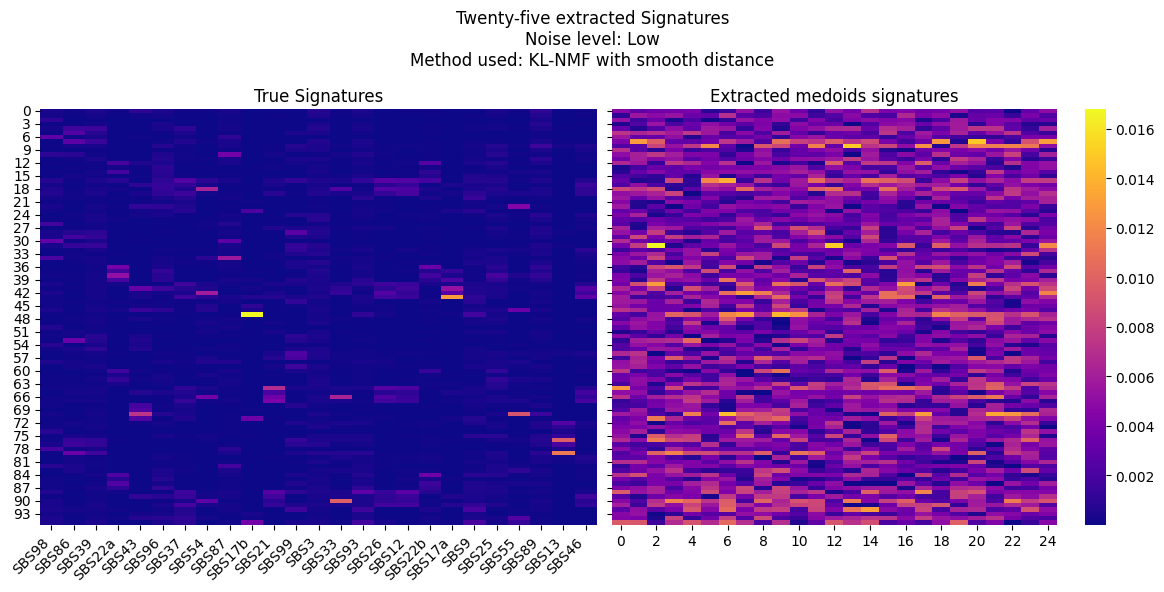

In [195]:
plot_all_runs_with_traverse(
    root_dir="results_csv_clean",
    s_values=["s_25"],
    distances=["smooth"],
    noise_values=[ "n_0.02"],
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged",
    cutoff=0.9,
    dist_metric="cos",
    plot_only_medoids=True,
    cmap="plasma",
    scale_heatmap=False
)


In [145]:
def compute_similarity_matrix(
    true_sigs: np.ndarray,
    est_sigs: np.ndarray,
    evaluation_method: str = "rearranged",  # or "not_arranged"
    cutoff: float = 0.9,
    dist: str = "cos"
):
    """
    1) If evaluation_method=='rearranged', use 'evaluation' (Hungarian) 
       to get idx_map and reorder extracted sigs in the row dimension.
    2) If evaluation_method=='not_arranged', use 'evaluation_figS1' 
       to get basic metrics (no reordering).
    3) Compute the full pairwise similarity matrix => shape (#extracted, #true).
    4) Return (similarity_mat, n_gt, n_det, tp, fp, fn, precision, recall, f1_score).
    """
    # Load your existing Hungarian or FigS1 evaluation
    if evaluation_method == "rearranged":
        # Hungarian approach
        (n_gt, n_det, tp, fp, fn, precision, recall, f1_score, idx_map) = evaluation(true_sigs, est_sigs, cutoff, dist)
        
        # Reorder extracted sigs in case #extracted is the "row" dimension
        est_sigs_aligned = reorder_extracted_signatures(est_sigs, idx_map)
        # Now compute the distance matrix on the final alignment
        # shape => (#extracted, #true)
        distance_mat = cdist(est_sigs_aligned.T, true_sigs.T, "cosine" if dist=="cos" else "correlation")
        similarity_mat = 1 - distance_mat
        
    elif evaluation_method == "not_arranged":
        # Figure S1 approach (no reordering)
        (n_gt, n_det, tp, fp, fn, precision, recall, f1_score) = evaluation_figS1(true_sigs, est_sigs, cutoff, dist)
        # We do not reorder
        distance_mat = cdist(est_sigs.T, true_sigs.T, "cosine" if dist=="cos" else "correlation")
        similarity_mat = 1 - distance_mat
    else:
        raise ValueError("evaluation_method must be 'rearranged' or 'not_arranged'")

    return similarity_mat, n_gt, n_det, tp, fp, fn, precision, recall, f1_score


In [218]:
def plot_all_runs_similarity(
    root_dir,
    s_values,
    distances,
    noise_values,
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged", # or "not_arranged"
    cutoff=0.9,
    dist_metric="cos",
    plot_only_medoids=True,
    cmap="viridis",
    vmin=0.0,  # Cosine/correlation-based similarity is in [0,1]
    vmax=1.0,
    apply_mask = True,
    annot = True
):
    """
    Iterates over all runs from traverse_folders, and for each matching subfolder 
    (Dw, Dkl, etc.), loads the CSV (just medoids if plot_only_medoids==True, else all CSVs),
    computes the (#extracted x #true) similarity matrix, then plots a single heatmap.

    Title includes s_val, distance, noise, run_folder, and the evaluation stats 
    (TP, FP, FN, precision, recall, F1).
    """

    # Cache ground truth to avoid re-reading multiple times
    ground_truth_cache = {}
    
    for s_val, dist, noise, run_folder, subfolder_path in traverse_folders(
        root_dir=root_dir,
        s_values=s_values,
        distances=distances,
        noise_values=noise_values
    ):
        subfolder_name = os.path.basename(subfolder_path)
        if subfolder_name not in subfolders:
            continue

        # 1) Load ground truth
        if s_val not in ground_truth_cache:
            gt_csv = os.path.join(root_dir, s_val, f"ground_truth_signatures_{s_val}.csv")
            if not os.path.exists(gt_csv):
                print(f"No ground truth: {gt_csv}, skipping {s_val}.")
                continue
            ground_truth_cache[s_val] = pd.read_csv(gt_csv, index_col=0).to_numpy()

        true_sigs = ground_truth_cache[s_val]

        if not os.path.isdir(subfolder_path):
            continue

        # 2) Collect target CSV files
        if plot_only_medoids:
            med_name = f"medoids_{subfolder_name}.csv"
            csv_files = [med_name] if os.path.exists(os.path.join(subfolder_path, med_name)) else []
        else:
            csv_files = [f for f in os.listdir(subfolder_path) if f.endswith(".csv")]

        for csv_file in csv_files:
            csv_path = os.path.join(subfolder_path, csv_file)
            if not os.path.exists(csv_path):
                continue

            est_sigs = pd.read_csv(csv_path, header=None).to_numpy()

            # 3) Compute similarity matrix + reorder if needed
            sim_mat, n_gt, n_det, tp, fp, fn, precision, recall, f1_score = compute_similarity_matrix(
                true_sigs, est_sigs,
                evaluation_method=evaluation_method,
                cutoff=cutoff,
                dist=dist_metric
            )
            
            # 4) Plot a single heatmap for sim_mat
            fig, ax = plt.subplots(figsize=(8, 6))

            # Create a mask to highlight cells above the cutoff threshold
            mask = sim_mat < cutoff if apply_mask else None

            # Plot heatmap without annotations, using mask to highlight cells surpassing the threshold
            sns.heatmap(
                sim_mat, 
                ax=ax, 
                cmap=cmap, 
                vmin=vmin, 
                vmax=vmax, 
                cbar=True, 
                annot=annot,  # No annotations
                mask=mask,    # Mask cells below threshold
                linewidths=0.5,  # Add grid for better visibility
                linecolor="black"  # Grid color
            )

            # Add a marker to highlight cells that exceed the cutoff
            # highlighted = np.where(sim_mat >= cutoff)
            # for i, j in zip(highlighted[0], highlighted[1]):
            #     ax.text(j + 0.5, i + 0.5, "X", ha='center', va='center', color='green', fontsize=8, fontweight='bold')

            # Label axes
            ax.set_xlabel("True Signatures")
            ax.set_ylabel("Extracted Signatures")

            # If it's the medoids file => "medoids" in title, else "Dkl_0" etc.
            if csv_file.startswith("medoids_"):
                file_desc = "medoids"
            else:
                file_desc = os.path.splitext(csv_file)[0]  # e.g. "Dkl_0"
            
            
            subfolder_name_mapping = {
                "Dkl": "KL-NMF",
                "Dw": "W-NMF"
            }

            # Mapping noise values to readable names
            noise_mapping = {
                "n_0.02": "Low",
                "n_0.04": "Medium",
                "n_0.06": "High"
            }

            signature_mapping = {
                "s_8": "Eight extracted Signatures",
                "s_15": "Fifteen extracted Signatures",
                "s_25": "Twenty-five extracted Signatures"
            }

            # Get the correct descriptive names
            method_name = subfolder_name_mapping.get(subfolder_name, subfolder_name)
            noise_desc = noise_mapping.get(noise, noise)
            signature_desc = signature_mapping.get(s_val, s_val)

# Update the figure title with descriptive names and line breaks
            fig_title = (
               # f"{evaluation_method.upper()} \n"
                f"{signature_desc}\n"
                f"Noise level: {noise_desc}\n"
                f"Method used: {method_name} with {dist} distance\n"
                f"Cutoff : {cutoff}\n"
                #f"(n_gt={n_gt}, n_det={n_det}, TP={tp}, FP={fp}, FN={fn}, prec={precision}, rec={recall}, F1={f1_score})"

                f"TP={tp}, FP={fp}, FN={fn}, prec={precision}, rec={recall}, F1={f1_score})"

            )
            # # Put run info + metrics in the figure title
            # fig_title = (
            #     f"{evaluation_method.upper()} similarity: {s_val}, {dist}, {noise}, run={run_folder}, file={csv_file}, cutoff={cutoff}\n"
            # )
            ax.set_title(fig_title, fontsize=10)

            plt.tight_layout()
            plt.show()


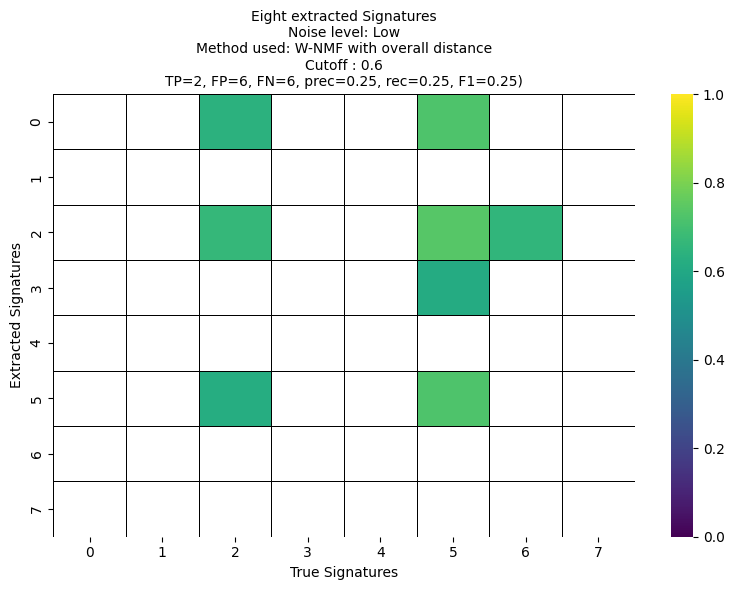

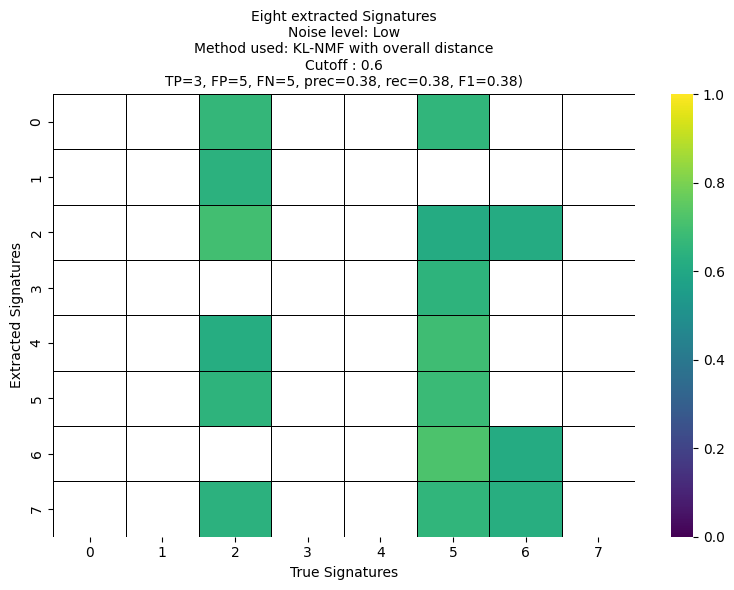

In [231]:
plot_all_runs_similarity(
    root_dir="results_csv_clean",
    s_values=["s_8"],
    distances=["overall"],#,"smooth","hamming","uniform"],
    noise_values=["n_0.02"],#,"n_0.04","n_0.06"],
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged", #rearranged not_arranged
    cutoff=0.60, 
    dist_metric="cos",
    plot_only_medoids=True,
    apply_mask=True,
    annot=False
)


### **F1 SCORES, SENSITIVITY ETC**

In [232]:

def collect_evaluation_metrics(
    root_dir,
    s_values,
    distances,
    noise_values,
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged",  # or "not_arranged"
    cutoff=0.9,
    dist_metric="cos",
    plot_only_medoids=True
):
    """
    Iterates over run folders (via traverse_folders), loads & evaluates 
    (Hungarian or FigS1) each matching CSV, 
    and collects metrics in a DataFrame.

    Returns a DataFrame with columns like:
      [
        's_val', 'distance', 'noise', 'run_folder', 'subfolder_name', 'csv_file',
        'n_gt','n_det','tp','fp','fn','precision','recall','f1_score'
      ]
    You can then plot this DataFrame to show trends across noise/distance/etc.
    """

    # Cache ground truth
    ground_truth_cache = {}
    records = []  # accumulate dicts here

    for s_val, dist, noise, run_folder, subfolder_path in traverse_folders(
        root_dir=root_dir,
        s_values=s_values,
        distances=distances,
        noise_values=noise_values
    ):
        subfolder_name = os.path.basename(subfolder_path)
        if subfolder_name not in subfolders:
            continue

        # Load ground truth
        if s_val not in ground_truth_cache:
            gt_csv = os.path.join(root_dir, s_val, f"ground_truth_signatures_{s_val}.csv")
            if not os.path.exists(gt_csv):
                print(f"No ground truth found for {s_val}, skipping.")
                continue
            ground_truth_cache[s_val] = pd.read_csv(gt_csv, index_col=0).to_numpy()

        true_sigs = ground_truth_cache[s_val]
        if not os.path.isdir(subfolder_path):
            continue

        # Gather CSV files
        if plot_only_medoids:
            med_name = f"medoids_{subfolder_name}.csv"
            csv_files = [med_name] if os.path.exists(os.path.join(subfolder_path, med_name)) else []
        else:
            csv_files = [f for f in os.listdir(subfolder_path) if f.endswith(".csv")]

        for csv_file in csv_files:
            csv_path = os.path.join(subfolder_path, csv_file)
            if not os.path.exists(csv_path):
                continue

            est_sigs = pd.read_csv(csv_path, header=None).to_numpy()

            # Evaluate
            if evaluation_method == "rearranged":
                (n_gt, n_det, tp, fp, fn, precision, recall, f1_score, idx_map) = evaluation(true_sigs, est_sigs, cutoff, dist_metric)
            elif evaluation_method == "not_arranged":
                (n_gt, n_det, tp, fp, fn, precision, recall, f1_score) = evaluation_figS1(true_sigs, est_sigs, cutoff, dist_metric)
            else:
                raise ValueError("evaluation_method must be 'rearranged' or 'not_arranged'")

            # Store in a dict
            row = {
                "s_val": s_val,
                "distance": dist,
                "noise": noise,
                "run_folder": run_folder,
                "subfolder_name": subfolder_name,
                "csv_file": csv_file,
                "n_gt": n_gt,
                "n_det": n_det,
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "precision": precision,
                "recall": recall,
                "f1_score": f1_score
            }
            records.append(row)

    # Convert to DataFrame
    df = pd.DataFrame.from_records(records)
    return df


In [245]:
df_metrics = collect_evaluation_metrics(
    root_dir="results_csv_clean",
    s_values=["s_8","s_15","s_25"],
    distances=["smooth","uniform","hamming","overall"],
    noise_values=["n_0.02","n_0.04","n_0.06"],
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged",  # or "not_arranged"
    cutoff=0.6
)
print(df_metrics.head())


  s_val distance   noise                                         run_folder  \
0   s_8   smooth  n_0.02  Results_20250117_154856__s_8_n_0.02__GRCh37_98...   
1   s_8   smooth  n_0.02  Results_20250117_154856__s_8_n_0.02__GRCh37_98...   
2   s_8   smooth  n_0.04  Results_20250117_155023__s_8_n_0.04__GRCh37_98...   
3   s_8   smooth  n_0.04  Results_20250117_155023__s_8_n_0.04__GRCh37_98...   
4   s_8   smooth  n_0.06  Results_20250117_155159__s_8_n_0.06__GRCh37_98...   

  subfolder_name         csv_file  n_gt  n_det  tp  fp  fn  precision  recall  \
0             Dw   medoids_Dw.csv     8      8   2   6   6       0.25    0.25   
1            Dkl  medoids_Dkl.csv     8      8   3   5   5       0.38    0.38   
2             Dw   medoids_Dw.csv     8      8   2   6   6       0.25    0.25   
3            Dkl  medoids_Dkl.csv     8      8   2   6   6       0.25    0.25   
4             Dw   medoids_Dw.csv     8      8   2   6   6       0.25    0.25   

   f1_score  
0      0.25  
1      0.3

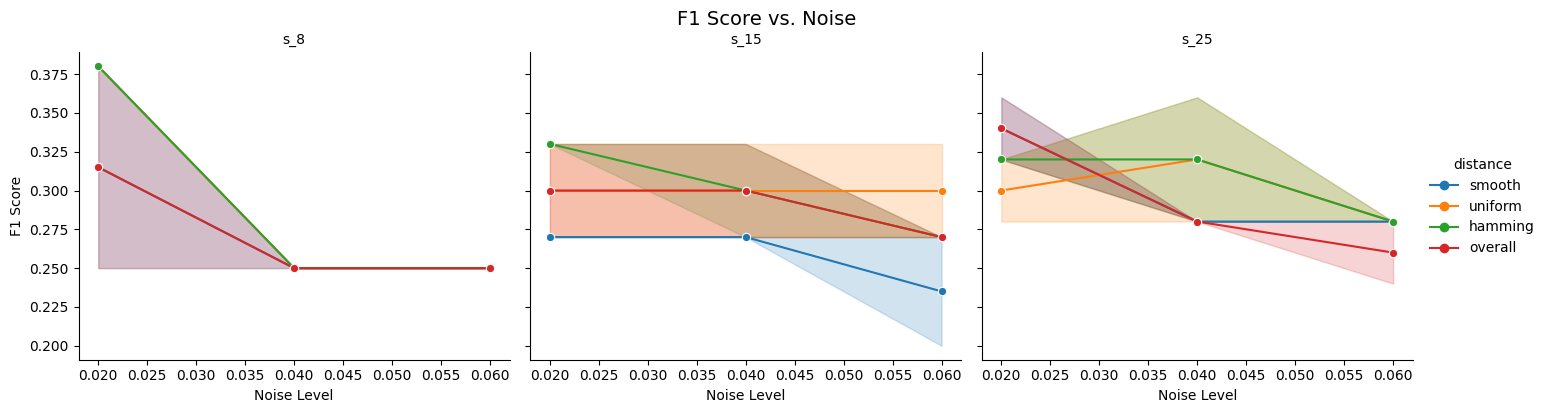

In [246]:


def plot_f1_by_noise(df, facet_col="s_val"):
    """
    Creates a line plot of F1 score vs. noise, 
    grouping by distance, faceting by s_val (optional).
    """
    # Make sure "noise" is something like numeric 0.02, 0.04, 0.06
    # If needed, parse the string "n_0.02" => 0.02:
    df["noise_val"] = df["noise"].str.replace("n_", "").astype(float)

    # For a line plot with Seaborn:
    g = sns.relplot(
        data=df,
        x="noise_val", y="f1_score",
        hue="distance", col=facet_col,   # separate subplot for each s_val
        kind="line", marker="o",
        col_wrap=3, height=4, aspect=1.2
    )
    g.set_titles("{col_name}")  # each subplot title is the s_val
    g.set_xlabels("Noise Level")
    g.set_ylabels("F1 Score")
    g.fig.suptitle("F1 Score vs. Noise", y=1.02, fontsize=14)
    plt.show()
plot_f1_by_noise(df_metrics)


In [247]:
def plot_f1_bar_chart(df, group_col="distance", facet_col="s_val"):
    """
    Creates a bar chart of F1, grouped by <group_col>, 
    and faceted by <facet_col>, 
    with noise on the x-axis (converted to numeric if needed).
    """
    df["noise_val"] = df["noise"].str.replace("n_", "").astype(float)
    # Sort by numeric noise so bars appear in ascending order
    df_sorted = df.sort_values("noise_val")

    g = sns.catplot(
        data=df_sorted,
        x="noise_val", y="f1_score",
        hue=group_col, col=facet_col,
        kind="bar",  # or 'point', 'box', etc.
        col_wrap=3, height=4, aspect=1.2
    )
    g.set_titles("{col_name}")
    g.set_xlabels("Noise Level")
    g.set_ylabels("F1 Score")
    g.fig.suptitle("F1 Score by Noise (Bar Chart)", y=1.02, fontsize=14)

    plt.show()


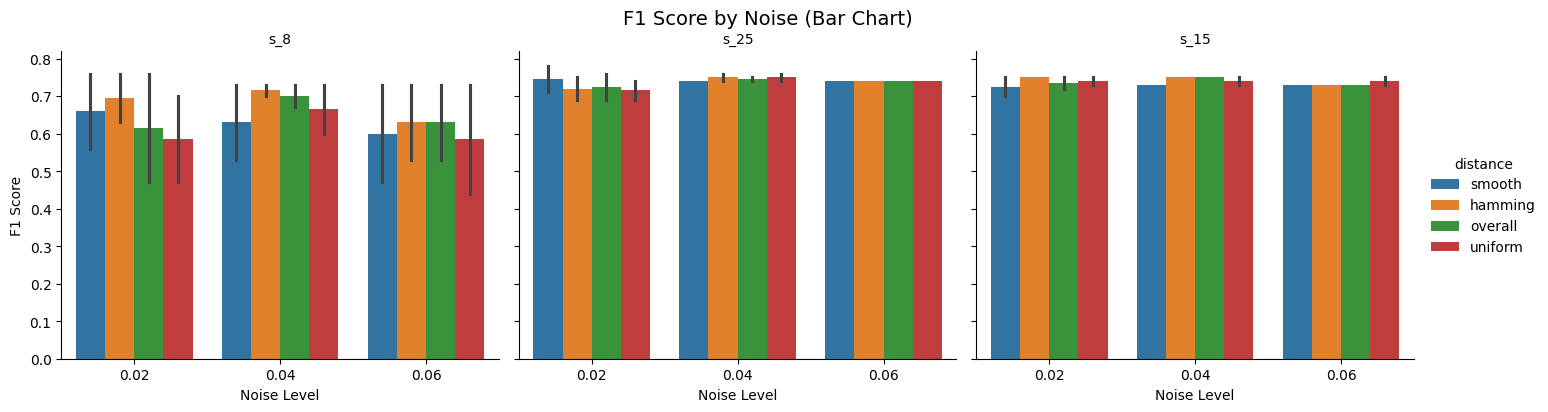

In [244]:
plot_f1_bar_chart(df_metrics, group_col="distance", facet_col="s_val")


In [276]:
def collect_metric_vs_cutoff_detailed(
    root_dir,
    s_values,
    distances,
    noise_values,
    subfolders=("Dw", "Dkl"),
    evaluation_method="rearranged",  # or "not_arranged"
    cutoff_range=[0.5,0.55,0.6,0.65, 0.7,0.75, 0.8,0.85, 0.9],
    dist_metric="cos",
    plot_only_medoids=True,
    metric="f1_score"
):
    """
    Similar to collect_f1_vs_cutoff, but returns *detailed* per-run rows.
    For each cutoff in cutoff_range:
      - For each run/folder:
        - Evaluate the metric (F1, recall, etc.)
        - Return a row with s_val, distance, noise, subfolder, cutoff, metric_value
    So you end up with a wide DataFrame. 

    Example columns:
      [ 's_val', 'distance', 'noise', 'subfolder', 'cutoff', 'metric_value' ]
    If you want to average or separate out Dw vs. Dkl, or s_8 vs. s_15, 
    you can do that in a groupby or in seaborn (facet/hue).
    """
    import os
    import pandas as pd
    import numpy as np

    data_rows = []
    ground_truth_cache = {}

    for cutoff_val in cutoff_range:
        for s_val, dist, noise, run_folder, subfolder_path in traverse_folders(
            root_dir=root_dir,
            s_values=s_values,
            distances=distances,
            noise_values=noise_values
        ):
            subfolder_name = os.path.basename(subfolder_path)
            if subfolder_name not in subfolders:
                continue

            # Load ground truth if not cached
            if s_val not in ground_truth_cache:
                gt_csv = os.path.join(root_dir, s_val, f"ground_truth_signatures_{s_val}.csv")
                if not os.path.exists(gt_csv):
                    continue
                ground_truth_cache[s_val] = pd.read_csv(gt_csv, index_col=0).to_numpy()

            true_sigs = ground_truth_cache[s_val]
            if not os.path.isdir(subfolder_path):
                continue

            # Gather CSV files (just medoids or all)
            if plot_only_medoids:
                med_name = f"medoids_{subfolder_name}.csv"
                csv_files = [med_name] if os.path.exists(os.path.join(subfolder_path, med_name)) else []
            else:
                csv_files = [f for f in os.listdir(subfolder_path) if f.endswith(".csv")]

            for csv_file in csv_files:
                csv_path = os.path.join(subfolder_path, csv_file)
                if not os.path.exists(csv_path):
                    continue

                est_sigs = pd.read_csv(csv_path, header=None).to_numpy()

                # Evaluate
                if evaluation_method == "rearranged":
                    n_gt, n_det, tp, fp, fn, prec, rec, f1, idx_map = evaluation(
                        true_sigs, est_sigs, cutoff=cutoff_val, dist=dist_metric
                    )
                else:
                    n_gt, n_det, tp, fp, fn, prec, rec, f1 = evaluation_figS1(
                        true_sigs, est_sigs, cutoff=cutoff_val, dist=dist_metric
                    )

                # Extract the desired metric
                if metric == "f1_score":
                    metric_val = f1
                elif metric == "precision":
                    metric_val = prec
                elif metric == "recall":
                    metric_val = rec
                else:
                    # default to F1 if unrecognized
                    metric_val = f1

                row = {
                    "s_val": s_val,
                    "distance": dist,
                    "noise": noise,
                    "subfolder": subfolder_name,  # Dw or Dkl
                    "cutoff": cutoff_val,
                    "metric_value": metric_val,
                    "tp": tp,
                    "fp": fp,
                    "fn": fn,
                    "precision": prec,
                    "recall": rec,
                    "f1_score": f1
                }
                data_rows.append(row)

    return pd.DataFrame(data_rows)


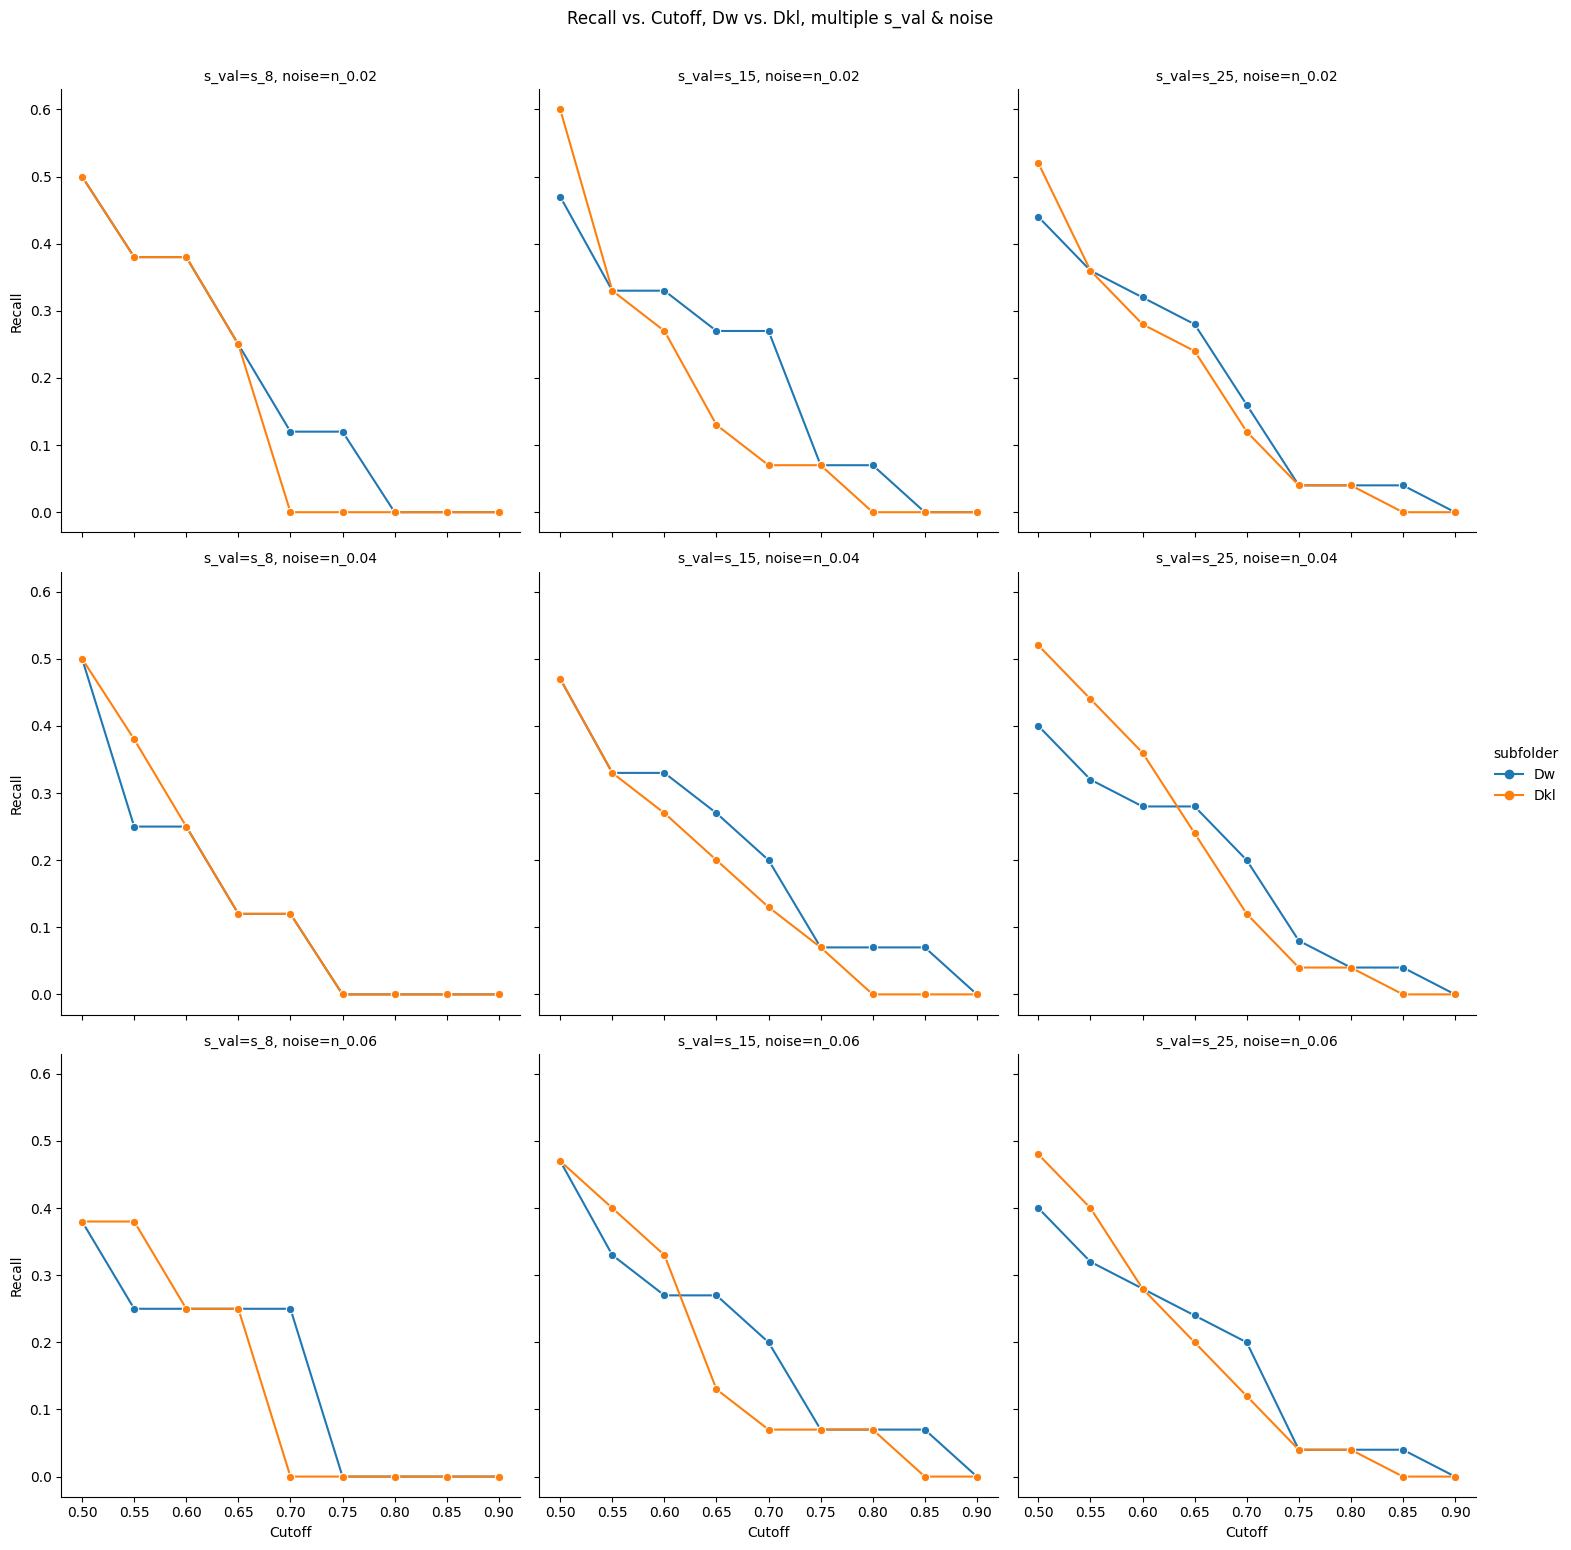

In [280]:
df = collect_metric_vs_cutoff_detailed(
    root_dir="results_csv_clean",
    s_values=["s_8","s_15","s_25"],
    distances=["uniform"],
    noise_values=["n_0.02","n_0.04","n_0.06"],
    subfolders=("Dw","Dkl"),
    cutoff_range=[0.5,0.55,0.6,0.65, 0.7,0.75, 0.8,0.85, 0.9],
    metric="recall"
)

g = sns.relplot(
    data=df,
    x="cutoff", y="metric_value",
    hue="subfolder",   # Dw vs. Dkl
    col="s_val",       # s_8 vs. s_15 => columns
    row="noise",       # n_0.02 vs. n_0.04 => rows
    kind="line", marker="o"
)
g.set_titles("s_val={col_name}, noise={row_name}")
g.set_xlabels("Cutoff")
g.set_ylabels("Recall")
g.fig.suptitle("Recall vs. Cutoff, Dw vs. Dkl, multiple s_val & noise", y=1.03)
plt.show()


   cutoff  avg_f1  n_runs
0    0.50   0.463      22
1    0.60   0.274      22
2    0.65   0.226      22
3    0.75   0.073      22
4    0.80   0.035      22
5    0.85   0.025      22
6    0.90   0.000      22
7    0.99   0.000      22


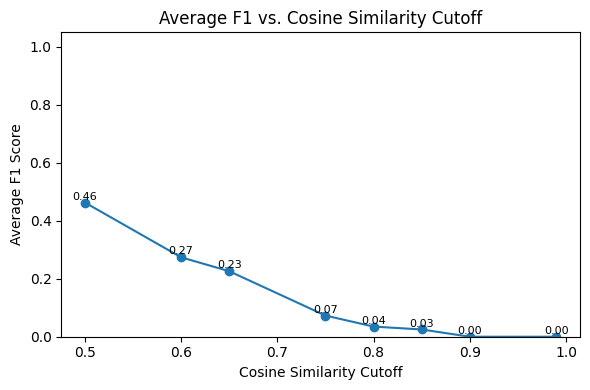

In [263]:
df_cutoffs = collect_f1_vs_cutoff(
    root_dir="results_csv_clean",
    s_values=["s_15"],            # or multiple
    distances=["uniform"],        # or multiple
    noise_values=["n_0.04"],      # or multiple
    subfolders=("Dw","Dkl"),
    evaluation_method="rearranged",  # or "not_arranged"
    cutoff_range=[0.5,0.6, 0.65, 0.75, 0.8, 0.85, 0.9, 0.99],  # or np.linspace(0.65,0.9,6)
    dist_metric="cos",
    plot_only_medoids=False
)

print(df_cutoffs)
plot_f1_vs_cutoff(df_cutoffs)


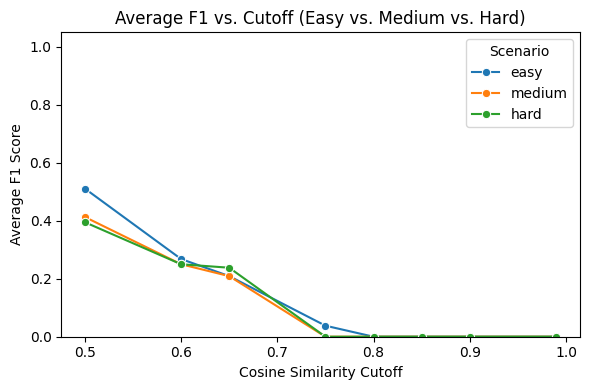

In [266]:
# Collect data for easy scenario
df_cutoffs_easy = collect_f1_vs_cutoff(
    root_dir="results_csv_clean",
    s_values=["s_8","s15","s25"],
    distances=["uniform", "hamming"],
    noise_values=["n_0.02"],  # "easy"
    subfolders=("Dw"),
    evaluation_method="rearranged",
    cutoff_range=[0.5,0.6, 0.65, 0.75, 0.8, 0.85, 0.9, 0.99],  # or np.linspace(0.65,0.9,6)
    plot_only_medoids=False
)
df_cutoffs_easy["scenario"] = "easy"

# Collect data for medium scenario with corrected noise value
df_cutoffs_med = collect_f1_vs_cutoff(
    root_dir="results_csv_clean",
    s_values=["s_8","s15","s25"],
    distances=["uniform", "hamming"],
    noise_values=["n_0.04"],  # Corrected to "medium"
    subfolders=("Dw"),

    evaluation_method="rearranged",
    cutoff_range=[0.5,0.6, 0.65, 0.75, 0.8, 0.85, 0.9, 0.99],  # or np.linspace(0.65,0.9,6)
    plot_only_medoids=False
)
df_cutoffs_med["scenario"] = "medium"

# Collect data for hard scenario
df_cutoffs_hard = collect_f1_vs_cutoff(
    root_dir="results_csv_clean",
    s_values=["s_8","s15","s25"],
    distances=["uniform", "hamming"],
    noise_values=["n_0.06"],  # "hard"
    subfolders=("Dw"),
    evaluation_method="rearranged",
    cutoff_range=[0.5,0.6, 0.65, 0.75, 0.8, 0.85, 0.9, 0.99],  # or np.linspace(0.65,0.9,6)
    plot_only_medoids=False

)
df_cutoffs_hard["scenario"] = "hard"

# Combine all datasets
df_combined = pd.concat([df_cutoffs_easy, df_cutoffs_med, df_cutoffs_hard], ignore_index=True)

# Plot the combined results
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.lineplot(data=df_combined, x="cutoff", y="avg_f1", hue="scenario", marker="o")
plt.title("Average F1 vs. Cutoff (Easy vs. Medium vs. Hard)")
plt.xlabel("Cosine Similarity Cutoff")
plt.ylabel("Average F1 Score")
plt.ylim(0, 1.05)
plt.legend(title="Scenario")
plt.tight_layout()
plt.show()
